In [1]:
import pandas as pd
from gensim.models import Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding, MaxPooling1D, Conv1D
from sklearn.model_selection import train_test_split
import numpy as np
from keras import models
from keras.layers import Dropout, Bidirectional
from keras import metrics
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Tokenizer

In [2]:


# Load the dataset
data = pd.read_csv('train.csv')

# Preprocessing
data['tweet'] = data['tweet'].str.lower()  # Convert to lowercase
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])
sequences = tokenizer.texts_to_sequences(data['tweet'])
word_index = tokenizer.word_index



Word2Vec

In [3]:
w2v_model = Word2Vec(sequences, window=5, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Prepare the embedding matrix
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    try:
        embedding_vector = w2v_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except KeyError:
        continue

GloVE

In [7]:
embeddings_index = {}
with open('glove.twitter.27B.100d.txt', 'r',  encoding='utf-8') as f:  
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs


embedding_matrix = np.zeros((len(word_index) + 1, 100))  # assuming 100-dimensional embeddings
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector



Data Prep

In [4]:
# Prepare the data
X = pad_sequences(sequences)
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Define the model


# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

Model Architecture - LSTM + GRU

In [5]:

# Define the model_LSTM_GRU
model_LSTM_GRU = Sequential()
model_LSTM_GRU.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
model_LSTM_GRU.add(Bidirectional(LSTM(128, return_sequences=True)))
model_LSTM_GRU.add(Dropout(0.2))
model_LSTM_GRU.add(Bidirectional(GRU(64)))
model_LSTM_GRU.add(Dropout(0.2))
model_LSTM_GRU.add(Dense(64, activation='relu'))
model_LSTM_GRU.add(Dense(3, activation='softmax'))  # Change the number of units to the number of classes

# Compile the model
model_LSTM_GRU.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=[
                  metrics.CategoricalAccuracy(name='accuracy'),
                  metrics.AUC(name='auc', multi_label=True),
              ])


Model Architecture LSTM +ConvGRU

In [9]:

# Define the model
model_LSTM_ConvGRU = Sequential()
model_LSTM_ConvGRU.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
model_LSTM_ConvGRU.add(Conv1D(128, 4, padding='same', activation='relu'))
model_LSTM_ConvGRU.add(MaxPooling1D(4))
model_LSTM_ConvGRU.add(Bidirectional(LSTM(128, return_sequences=True)))
model_LSTM_ConvGRU.add(Dropout(0.2))
model_LSTM_ConvGRU.add(Bidirectional(GRU(64)))
model_LSTM_ConvGRU.add(Dropout(0.2))
model_LSTM_ConvGRU.add(Dense(64, activation='relu'))
model_LSTM_ConvGRU.add(Dense(3, activation='softmax')) # Change the number of units to the number of classes

# Compile the model
model_LSTM_ConvGRU.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=[
                  metrics.CategoricalAccuracy(name='accuracy'),
                  metrics.AUC(name='auc', multi_label=True),
              ])




Model Architecture - LSTM

In [6]:
# Define the model
model_LSTM = Sequential()
model_LSTM.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
model_LSTM.add(Bidirectional(LSTM(128, return_sequences=False)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(64, activation='relu'))
model_LSTM.add(Dense(3, activation='softmax'))  # Change the number of units to the number of classes

# Compile the model
model_LSTM.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=[
                  metrics.CategoricalAccuracy(name='accuracy'),
                  metrics.AUC(name='auc', multi_label=True),
              ])


Model Architecture - GRU

In [23]:
# Define the model
model_GRU = Sequential()
model_GRU.add(Embedding(len(word_index) + 1, 100, weights=[embedding_matrix], trainable=False))
model_GRU.add(Dropout(0.2))
model_GRU.add(Bidirectional(GRU(64)))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(64, activation='relu'))
model_GRU.add(Dense(3, activation='softmax'))  # Change the number of units to the number of classes

# Compile the model
model_GRU.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=[
                  metrics.CategoricalAccuracy(name='accuracy'),
                  metrics.AUC(name='auc', multi_label=True),
              ])


Over Sampling

In [56]:

# Define the oversampling strategy
smote = SMOTE(sampling_strategy='auto')

# Fit and apply the transform
X_over, y_over = smote.fit_resample(X_train, y_train)
class_labels = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}

# Print some examples from the original training data
print("Original training data:")
for i in np.random.choice(X_train.shape[0], 10):
    print(f'Tweet: {tokenizer.sequences_to_texts([X_train[i]])[0]}')
    print(f'Class: {class_labels[y_train[i]]}')
    print('---')

# Print some examples from the oversampled training data
print("\nOversampled training data:")
for i in np.random.choice(X_over.shape[0], 10):
    print(f'Tweet: {tokenizer.sequences_to_texts([X_over[i]])[0]}')
    print(f'Class: {class_labels[y_over[i]]}')
    print('---')



Original training data:
Tweet: rt stevstiffler if her bio says only god can judge me she's a hoe
Class: offensive language
---
Tweet: rt l1ldebbie so it's rude to talk about fat bitches but it's cool to talk about skinny bitches cus i know alot of thick hoes on the ver 8230
Class: offensive language
---
Tweet: fernandezice quit being a pussy
Class: offensive language
---
Tweet: rt juicygenie sheryl crow be my mom
Class: neither
---
Tweet: them quiet girls be hoes to watch out
Class: offensive language
---
Tweet: would you be interested in some eggplant rt nittyscottmc twerk on me http t co 75uftruvdz
Class: neither
---
Tweet: yaaasss rt lovemsliz when a hoe is talking about how they really don't be hoes 128530 like girl if you gotta explain it 9 10 a hoe
Class: offensive language
---
Tweet: i picked welbeck for my team i have to be some kind of cunt yes
Class: offensive language
---
Tweet: dear god forgive us for a moral slope of values shacking is just a pretty word for perpetual forn

Training and Saving Model

In [6]:
# Train the model with the oversampled data
#model.fit(X_over, y_over, validation_data=(X_test, y_test), epochs=10)
#model.fit(X_over, y_over, validation_data=(X_test, y_test_one_hot), epochs=10)
#y_over_one_hot = to_categorical(y_over)
#model.fit(X_over, y_over_one_hot, validation_data=(X_test, y_test_one_hot), epochs=10)
model_LSTM_GRU.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=10)

# Save the model
model_LSTM_GRU.save('model_LSTM_GRU_Word2Vec.keras')


Epoch 1/10
620/620 [==============================] - 263s 408ms/step - loss: 0.9056 - accuracy: 0.7742 - auc: 0.4963 - val_loss: 0.7786 - val_accuracy: 0.7702 - val_auc: 0.5000
Epoch 2/10
620/620 [==============================] - 242s 390ms/step - loss: 0.7219 - accuracy: 0.7753 - auc: 0.5004 - val_loss: 0.6957 - val_accuracy: 0.7702 - val_auc: 0.5000
Epoch 3/10
620/620 [==============================] - 235s 379ms/step - loss: 0.6773 - accuracy: 0.7753 - auc: 0.5011 - val_loss: 0.6753 - val_accuracy: 0.7702 - val_auc: 0.5000
Epoch 4/10
620/620 [==============================] - 172s 278ms/step - loss: 0.6660 - accuracy: 0.7753 - auc: 0.4955 - val_loss: 0.6691 - val_accuracy: 0.7702 - val_auc: 0.5000
Epoch 5/10
620/620 [==============================] - 209s 337ms/step - loss: 0.6627 - accuracy: 0.7753 - auc: 0.5062 - val_loss: 0.6669 - val_accuracy: 0.7702 - val_auc: 0.5000
Epoch 6/10
620/620 [==============================] - 139s 224ms/step - loss: 0.6618 - accuracy: 0.7753 - auc:

Testing Models

155/155 [==============================] - 5s 23ms/step


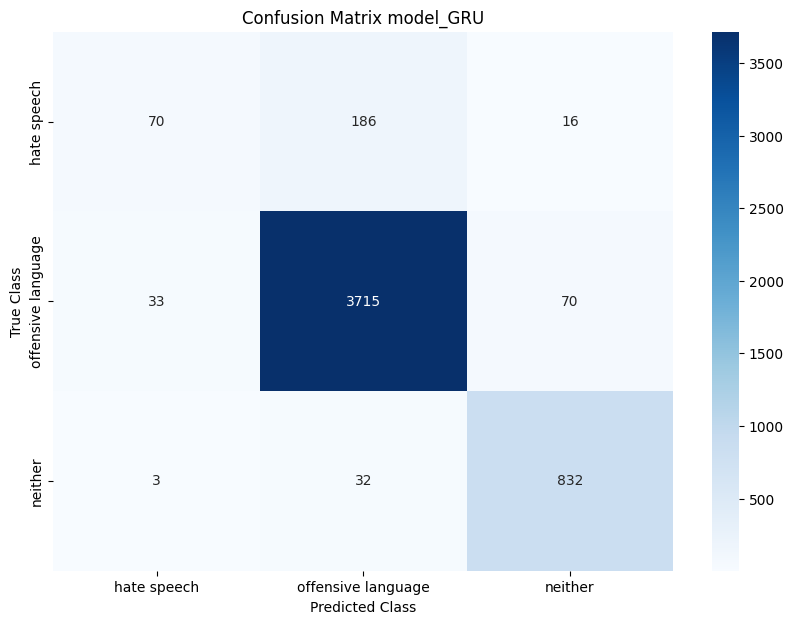

C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


155/155 [==============================] - 6s 31ms/step


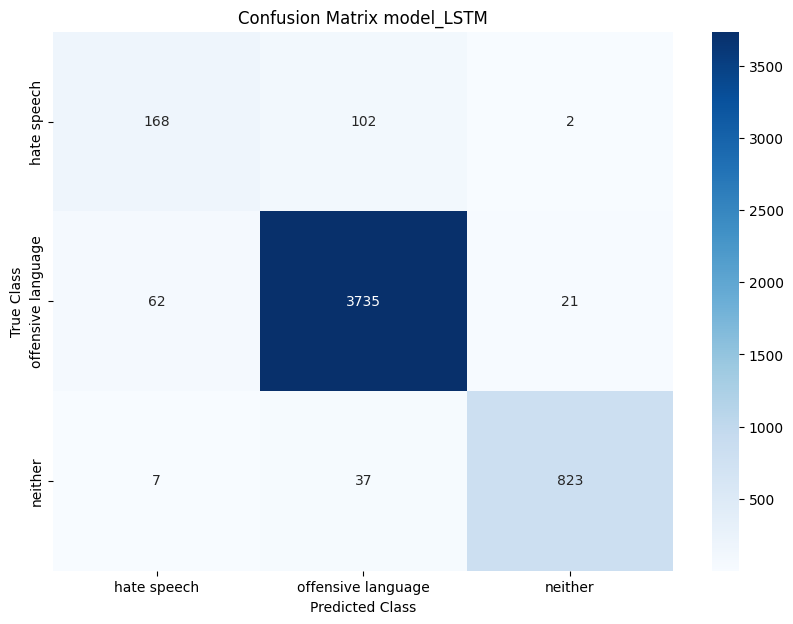

C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


155/155 [==============================] - 4s 14ms/step


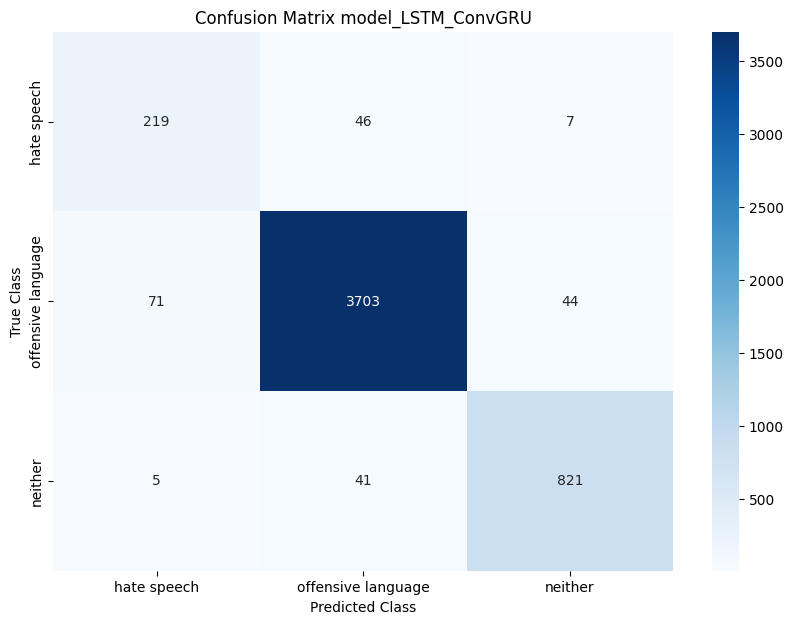

C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


155/155 [==============================] - 4s 14ms/step


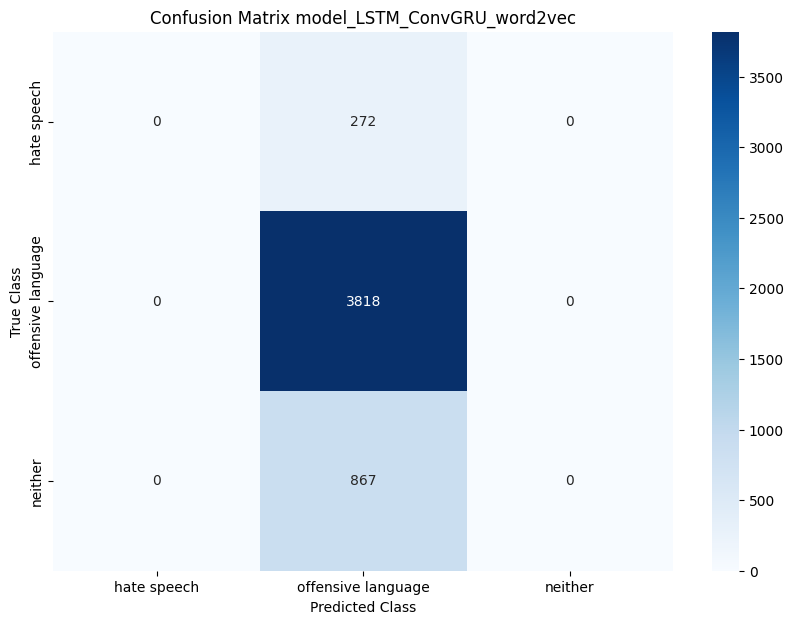

C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

155/155 [==============================] - 8s 45ms/step


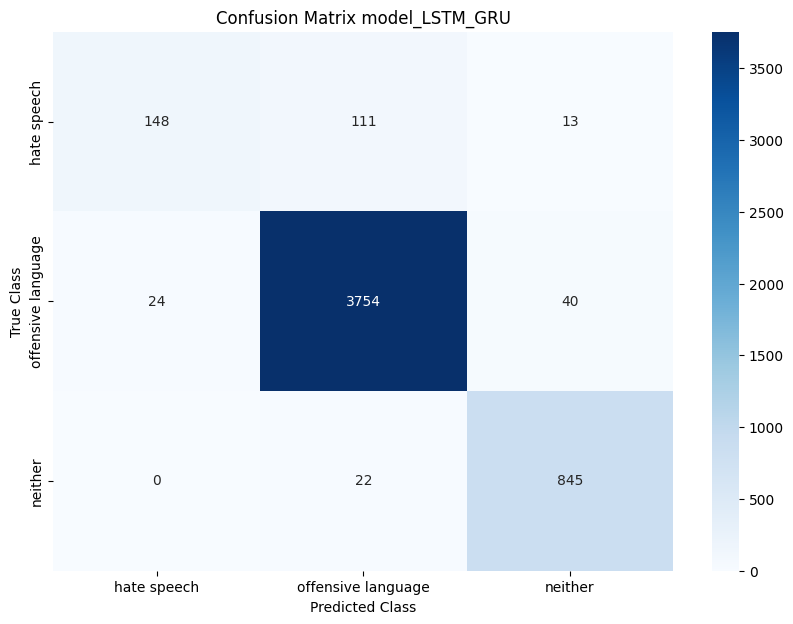

C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(
C:\Users\seher\AppData\Local\Temp\ipykernel_18440\3789055133.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(


155/155 [==============================] - 9s 48ms/step


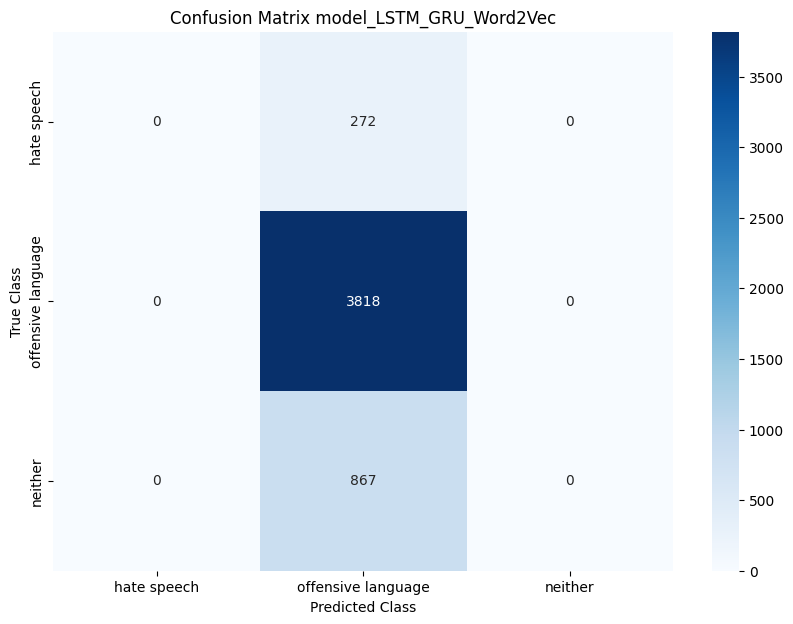

C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\seher\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1469

In [7]:
import os
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras import models

# Define the labels of your classes
class_labels = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}
labels = ["Hate Speech", "Offensive Language", "Neither"]

# Initialize a DataFrame to store the results
results = pd.DataFrame()

# Iterate over the models in the working directory
for filename in os.listdir("."):
    if filename.endswith(".h5") or filename.endswith(".keras"):
        # Load the model
        model = models.load_model(filename)
        loss, accuracy, auc = model.evaluate(X_test, y_test_one_hot, verbose=0)

        # Predict the classes of the test data
        y_pred_probs = model.predict(X_test)
        y_pred = y_pred_probs.argmax(axis=-1)
        cm = confusion_matrix(y_test, y_pred)

        # Define the labels of the confusion matrix

        labels = ["hate speech", "offensive language", "neither"]

        # Create a DataFrame for the confusion matrix for better visualization
        filename = filename.replace('.keras', '')
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)

        # Plot the confusion matrix

        plt.figure(figsize=(10, 7))

        sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix " + filename)

        plt.ylabel("True Class")

        plt.xlabel("Predicted Class")
        plt.savefig(filename + '.png')
        plt.show()
        # Generate the classification report
        report_dict = classification_report(
            y_test, y_pred, target_names=labels, output_dict=True
        )

        for label in labels:
            results = results.append(
                {
                    "Model": filename,
                    "Accuracy": accuracy,
                    "AUC": auc,
                    "Class Labels": label,
                    "Precision": report_dict[label]["precision"],
                    "Recall": report_dict[label]["recall"],
                    "F1-Score": report_dict[label]["f1-score"],
                    "Support": report_dict[label]["support"],
                },
                ignore_index=True,
            )

# Write results to Excel file
results.to_excel("model_evaluation_results.xlsx", index=False)


# Print some examples from the test data


# for i in range(10):
#   print(f"Tweet: {tokenizer.sequences_to_texts([X_test[i]])[0]}")
## print(f"Predicted class: {class_labels[y_pred[i]]}")
# print("---")



# Calculate the confusion matrix

Example Tweets

In [24]:
# Define your example tweet
model =models.load_model('model_CCE.keras')
class_labels = {0: 'hate speech', 1: 'offensive language', 2: 'neither'}
example_tweet = "birds and bees"

# Preprocess the tweet
example_sequence = tokenizer.texts_to_sequences([example_tweet])
example_padded_sequence = pad_sequences(example_sequence, maxlen=X_test.shape[1])

# Predict the class of the example tweet
example_pred_probs = model.predict(example_padded_sequence)
example_pred = example_pred_probs.argmax(axis=-1)

# Print the predicted class
print(f'Predicted class: {class_labels[example_pred[0]]}')


1/1 [==============================] - 1s 866ms/step
Predicted class: neither
